In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="white", rc={"grid.color": "lightgray"})
plt.rcParams["figure.dpi"] = 300

In [2]:
environments = [x for x in os.listdir(".") if os.path.isdir(x) if x != "HalfCheetah"]
results = {env: pd.read_csv(os.path.join(env, "results.csv")) for env in environments}
lambdas = {
    env: [
        pd.read_csv(os.path.join(env, lmbaa))
        for lmbaa in [x for x in sorted(os.listdir(env)) if x.startswith("lambda")]
    ]
    for env in environments
}
components = {
    env: [
        pd.read_csv(os.path.join(env, comp))
        for comp in [x for x in sorted(os.listdir(env)) if x.startswith("component")]
    ]
    for env in environments
}
colors = {
    "DyLam": "red",
    "SAC": "gray",
    "PPO": "gray",
    "drQ": "green",
    "HDDDQN": "gray",
}
env_steps = {
    "Humanoid": 1e6 - 1,
    "LunarLander": 1e6 - 1,
    "LunarLanderContinuous": 1e6 - 1,
    "FrozenLake": 6e5 - 1,
    "HalfCheetah": 1e6 - 1,
    "SSLGoTo": 3e5 - 1,
}
env_alphas = {
    "Humanoid": 1 - 0.99999,
    "LunarLander": 1 - 0.99,
    "LunarLanderContinuous": 1 - 0.9999,
    "FrozenLake": 1 - 0.9,
    "HalfCheetah": 1 - 0.999,
    "SSLGoTo": 1 - 0.9999,
}
env_ylimits = {
    "Humanoid": (0, 10000),
    "LunarLander": (-100, 100.1),
    "LunarLanderContinuous": (-100, 100.1),
    "FrozenLake": (0, 1.01),
    "HalfCheetah": (0, 15000),
    "SSLGoTo": (0, 1.01),
}
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

In [3]:
def calculate_ema(data, alpha):
    ema = np.zeros_like(data)  # Initialize an array for the EMA values
    ema[0] = data[0]  # Set the initial value of the EMA to the first data point

    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]  # Calculate the EMA

    return ema

In [4]:
def plot_results(env, results):
    methods = list(
        set(
            [
                x.split("method: ")[1].split(" - ep_info/")[0]
                for x in results[env].keys()
                if x != "Step"
            ]
        )
    )
    # plot figure
    rew_name = results[env].keys()[1].split(" - ep_info/")[1]
    plt.figure(figsize=(10, 5))
    for method in methods:
        just_necessary = (
            method.split("_")[1] if len(method.split("_")) > 1 else method.upper()
        )

        # Mean
        res = results[env][["Step", f"method: {method} - ep_info/{rew_name}"]].dropna()
        res["Smoothed"] = calculate_ema(
            res[f"method: {method} - ep_info/{rew_name}"].values, env_alphas[env]
        )
        x = res["Step"][res["Step"] <= env_steps[env]]
        y = res["Smoothed"][res["Step"] <= env_steps[env]]
        plt.plot(
            x,
            y,
            label=just_necessary,
            color=colors[just_necessary],
        )
        std_error = res[f"method: {method} - ep_info/{rew_name}"].std()
        plt.fill_between(
            x,
            y - std_error,
            y + std_error,
            alpha=0.1,
            color=colors[just_necessary],
        )
    plt.legend()
    plt.title(rew_name.capitalize().replace("_", " "), fontsize=10, fontweight="bold")
    plt.ylim(env_ylimits[env])
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xlabel(
        "Steps",
        fontsize=10,
    )
    plt.grid(True)
    plt.savefig(f"{env}/results.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

In [5]:
import math


def plot_grid(lambdas, components, env):
    if len(lambdas[env]) < 4:
        nrows = 1
        ncols = len(lambdas[env])
        if len(lambdas[env]) % 3:
            size = (7, 2)
        else:
            size = (16, 3)
    else:
        size = (8, 4)
        nrows = math.ceil(len(lambdas[env]) / 2)
        ncols = math.ceil(len(lambdas[env]) / 2)
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=size,
        sharex=True,
    )
    for i, lmbda in enumerate(lambdas[env]):
        ax1 = axes[i // 2, i % 2] if len(lambdas[env]) > 3 else axes[i]
        # Apply moving average smoothing
        window_size = 100
        weights = np.repeat(1.0, window_size) / window_size
        smoothed = np.convolve(
            components[env][i][components[env][i].keys()[1]], weights, "same"
        )
        comp_key = components[env][i].keys()[1].split("ep_info/")[1].title()
        (p1,) = ax1.plot(
            components[env][i]["Step"][:-1],
            smoothed[:-1],
            color="red",
            alpha=0.5,
            label="Reward",
        )

        ax1.title.set_text(comp_key)
        ax1.title.set_fontsize(10)
        ax1.title.set_fontweight("bold")
        ax1.tick_params(axis="y", labelcolor="red")
        ax1.axvline(color="grey")
        ax1.axhline(color="grey")
        ax1.grid(True)

        ax1.yaxis.set_major_formatter(formatter)
        ax1.xaxis.set_major_formatter(formatter)

        ax1_twin = ax1.twinx()
        ax1_twin.grid(False)

        (p2,) = ax1_twin.plot(
            lmbda["Step"][:-1],
            lmbda[lmbda.keys()[1]][:-1],
            color="blue",
            label="lambda",
        )
        ax1_twin.tick_params(axis="y", labelcolor="blue")

        if i % 2:
            ax1_twin.set_yticks([0, 0.5, 1])
        else:
            # remove yticks
            ax1_twin.set_yticks([])

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.2, wspace=0.35)
    if len(lambdas[env]) > 3:
        fig.align_ylabels(axes[:, 1])
    else:
        fig.align_ylabels(axes)
    fig.legend(
        handles=[p1, p2],
        loc="lower center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    fig.set_dpi(300)
    plt.savefig(f"{env}/DyLam_analysis.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

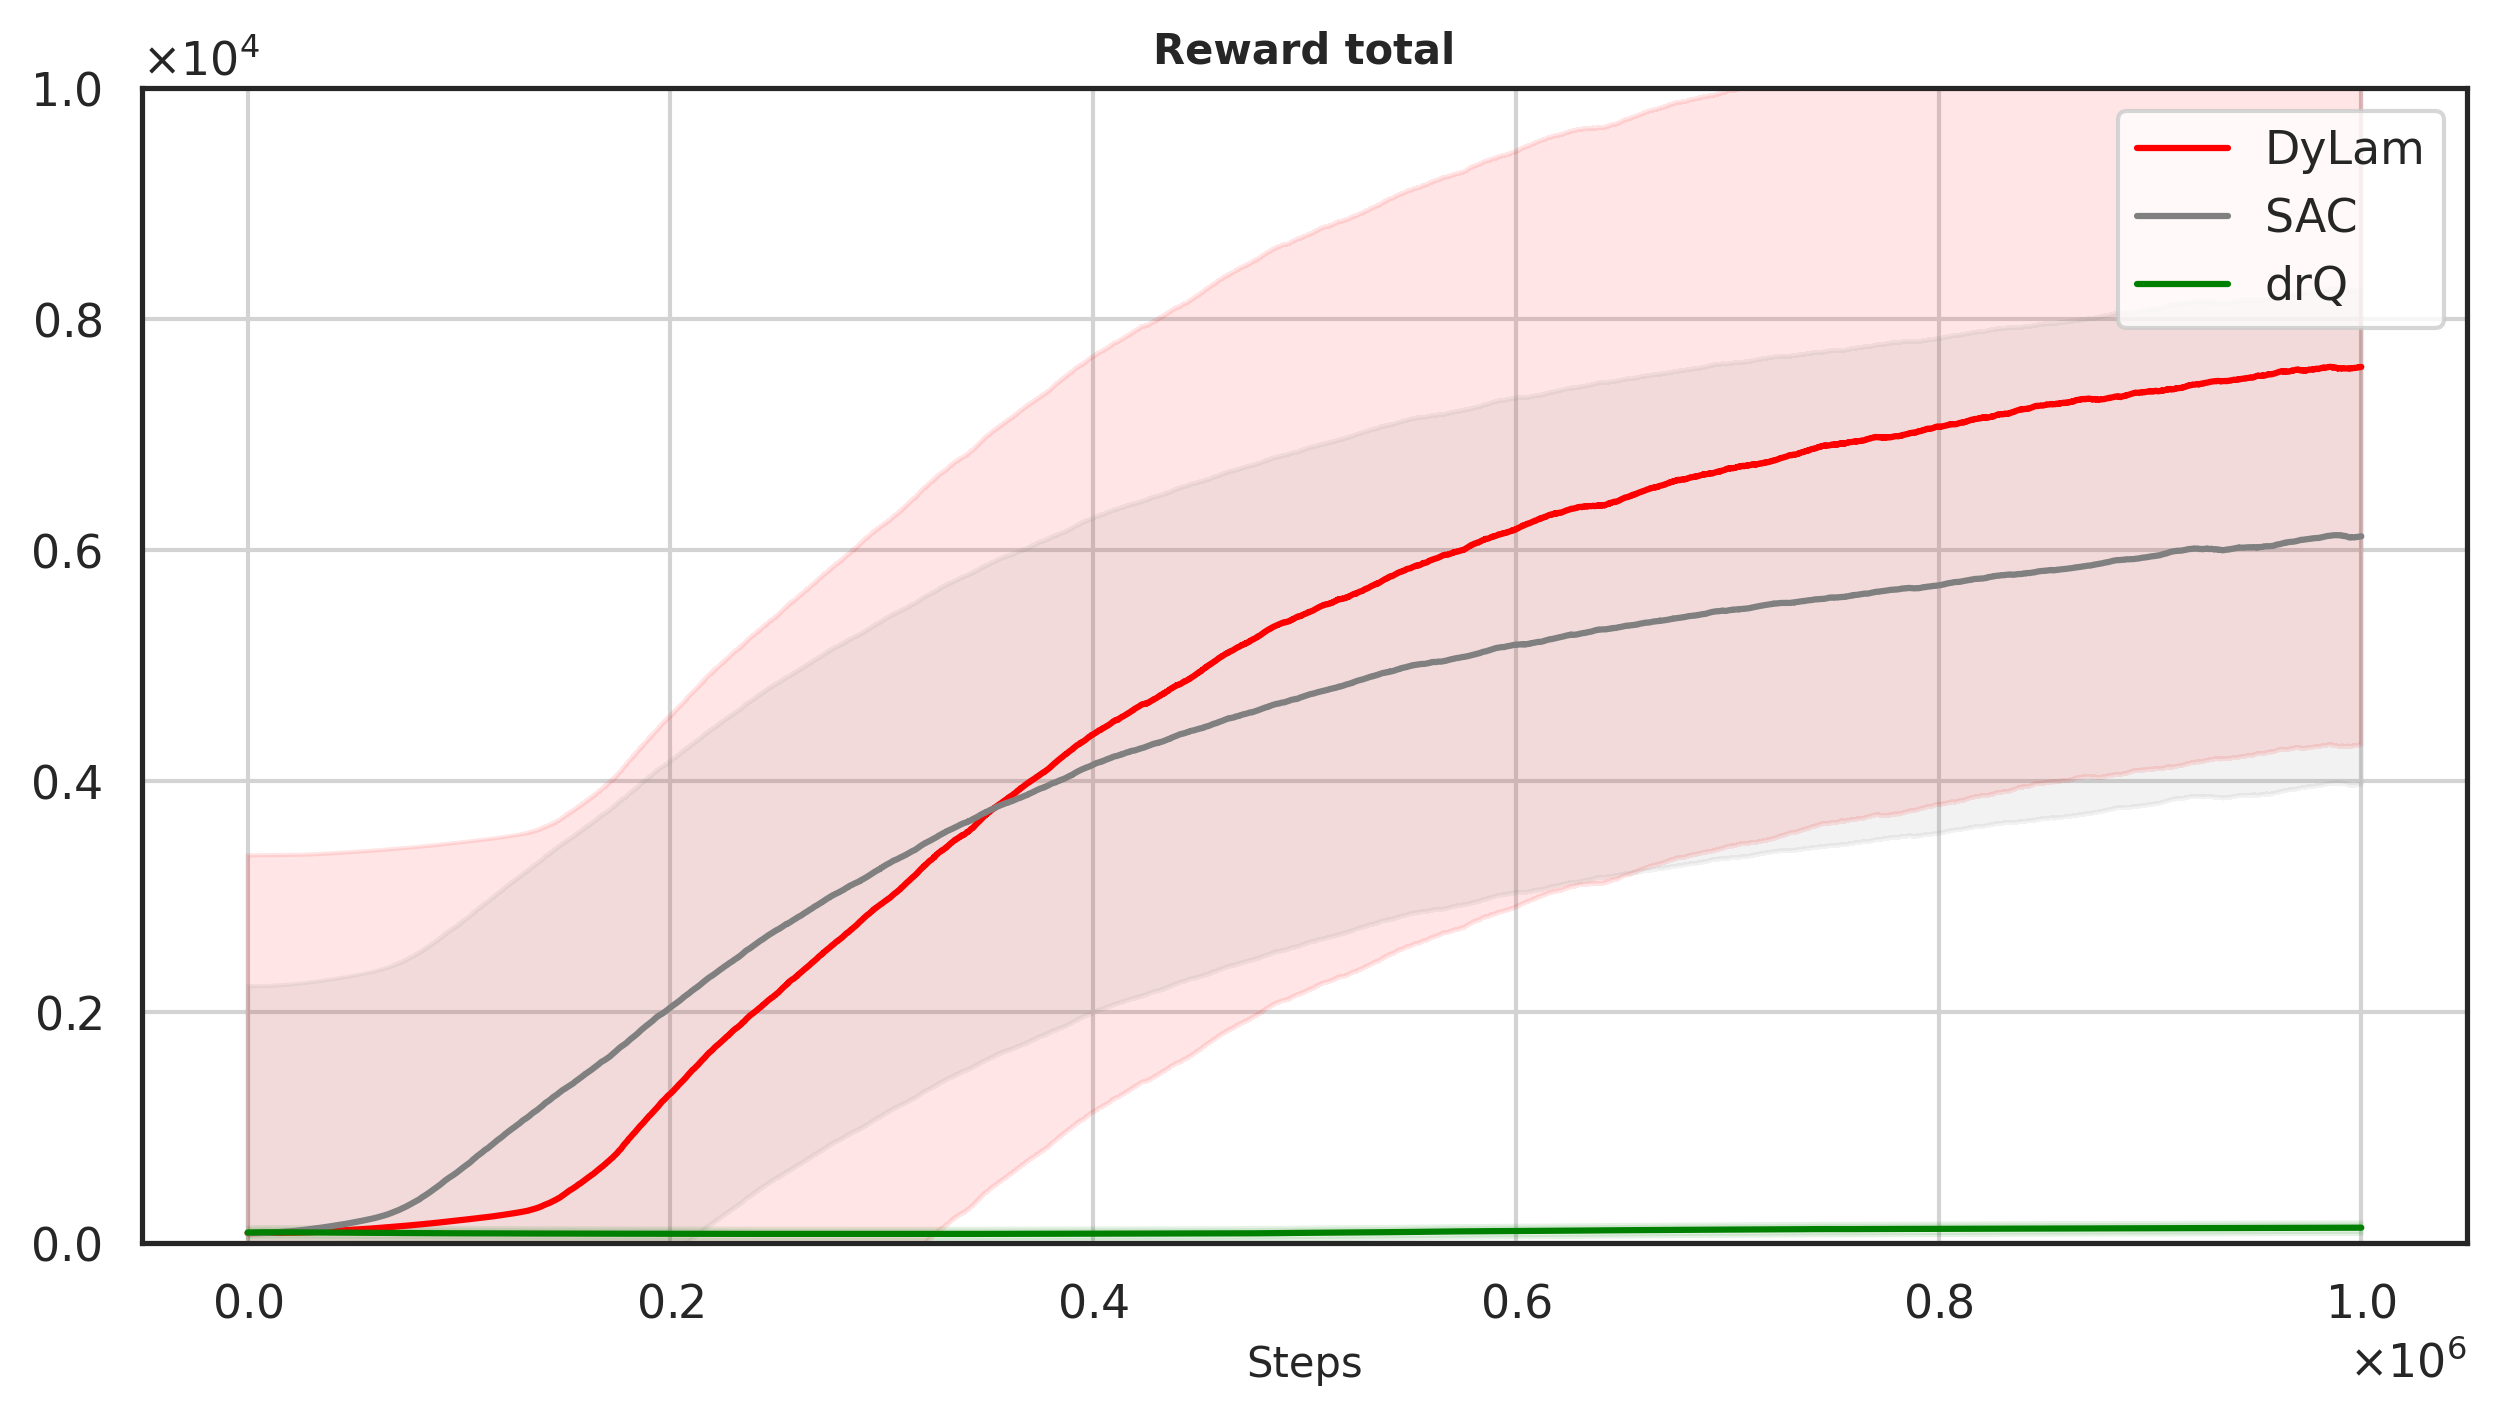

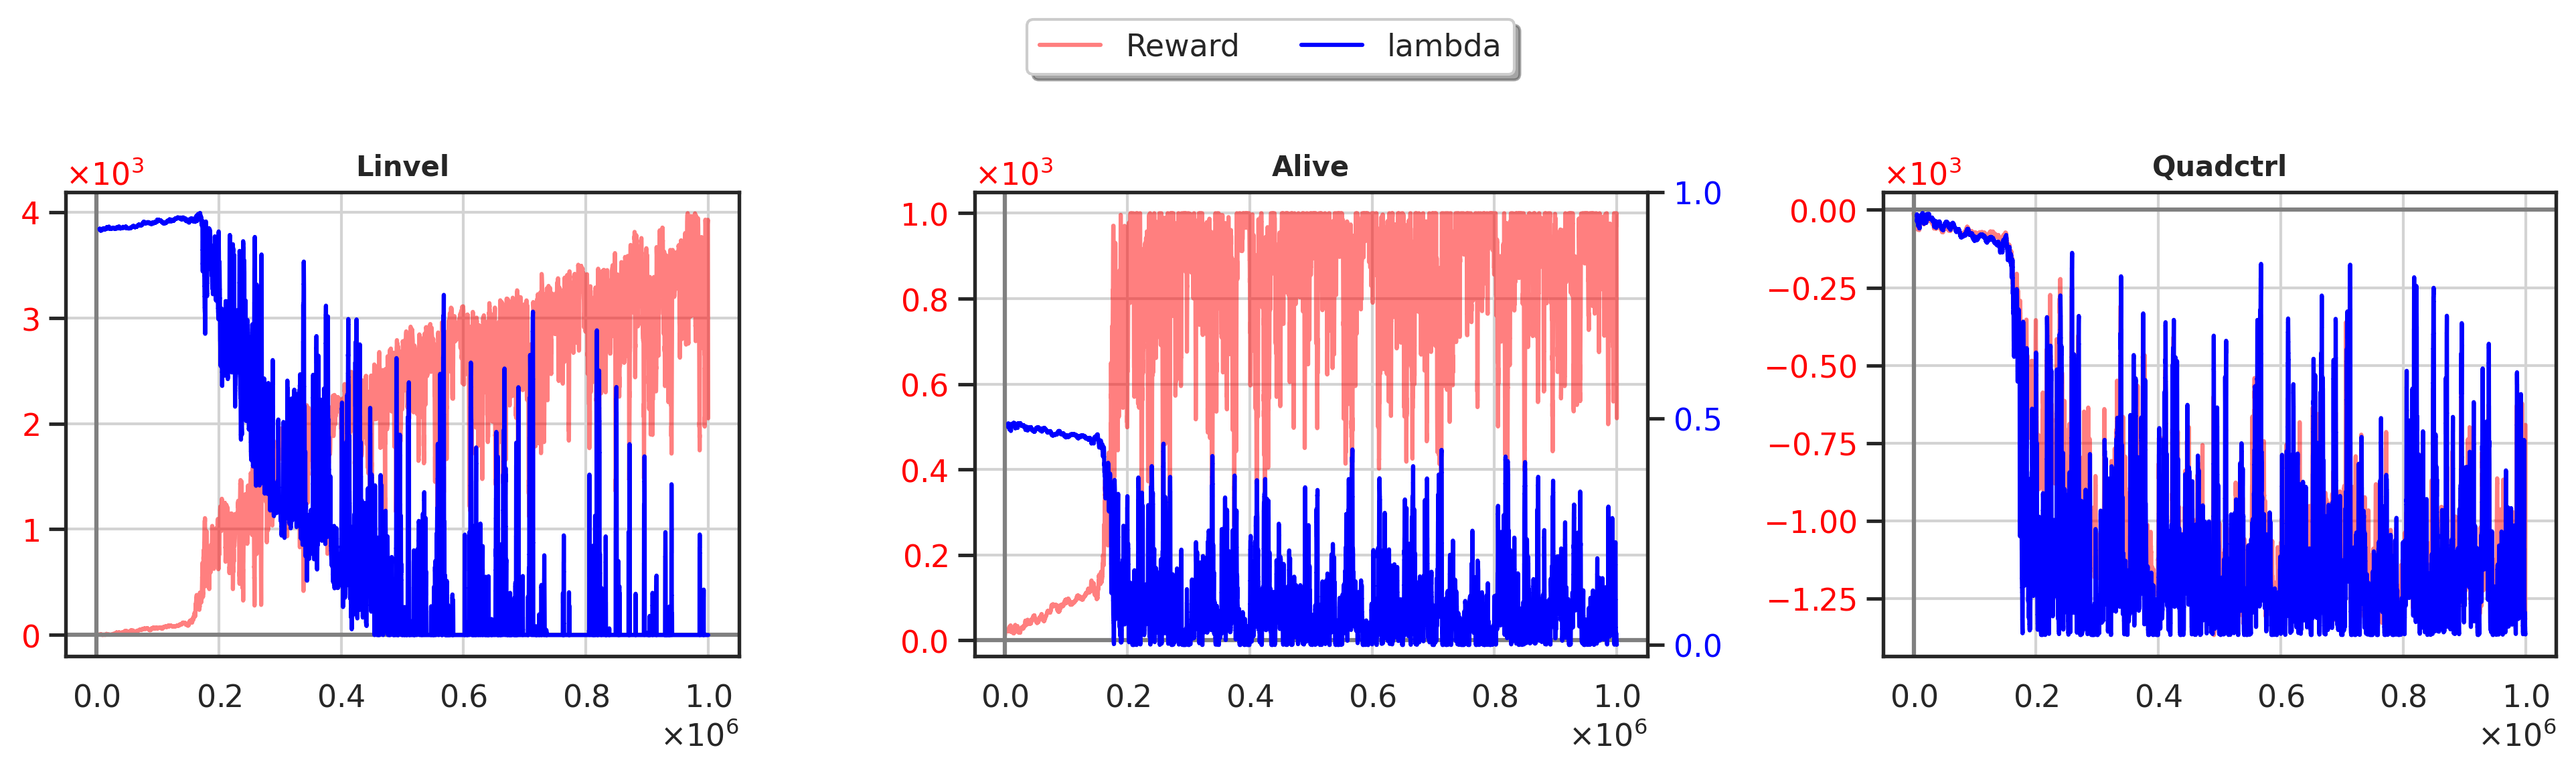

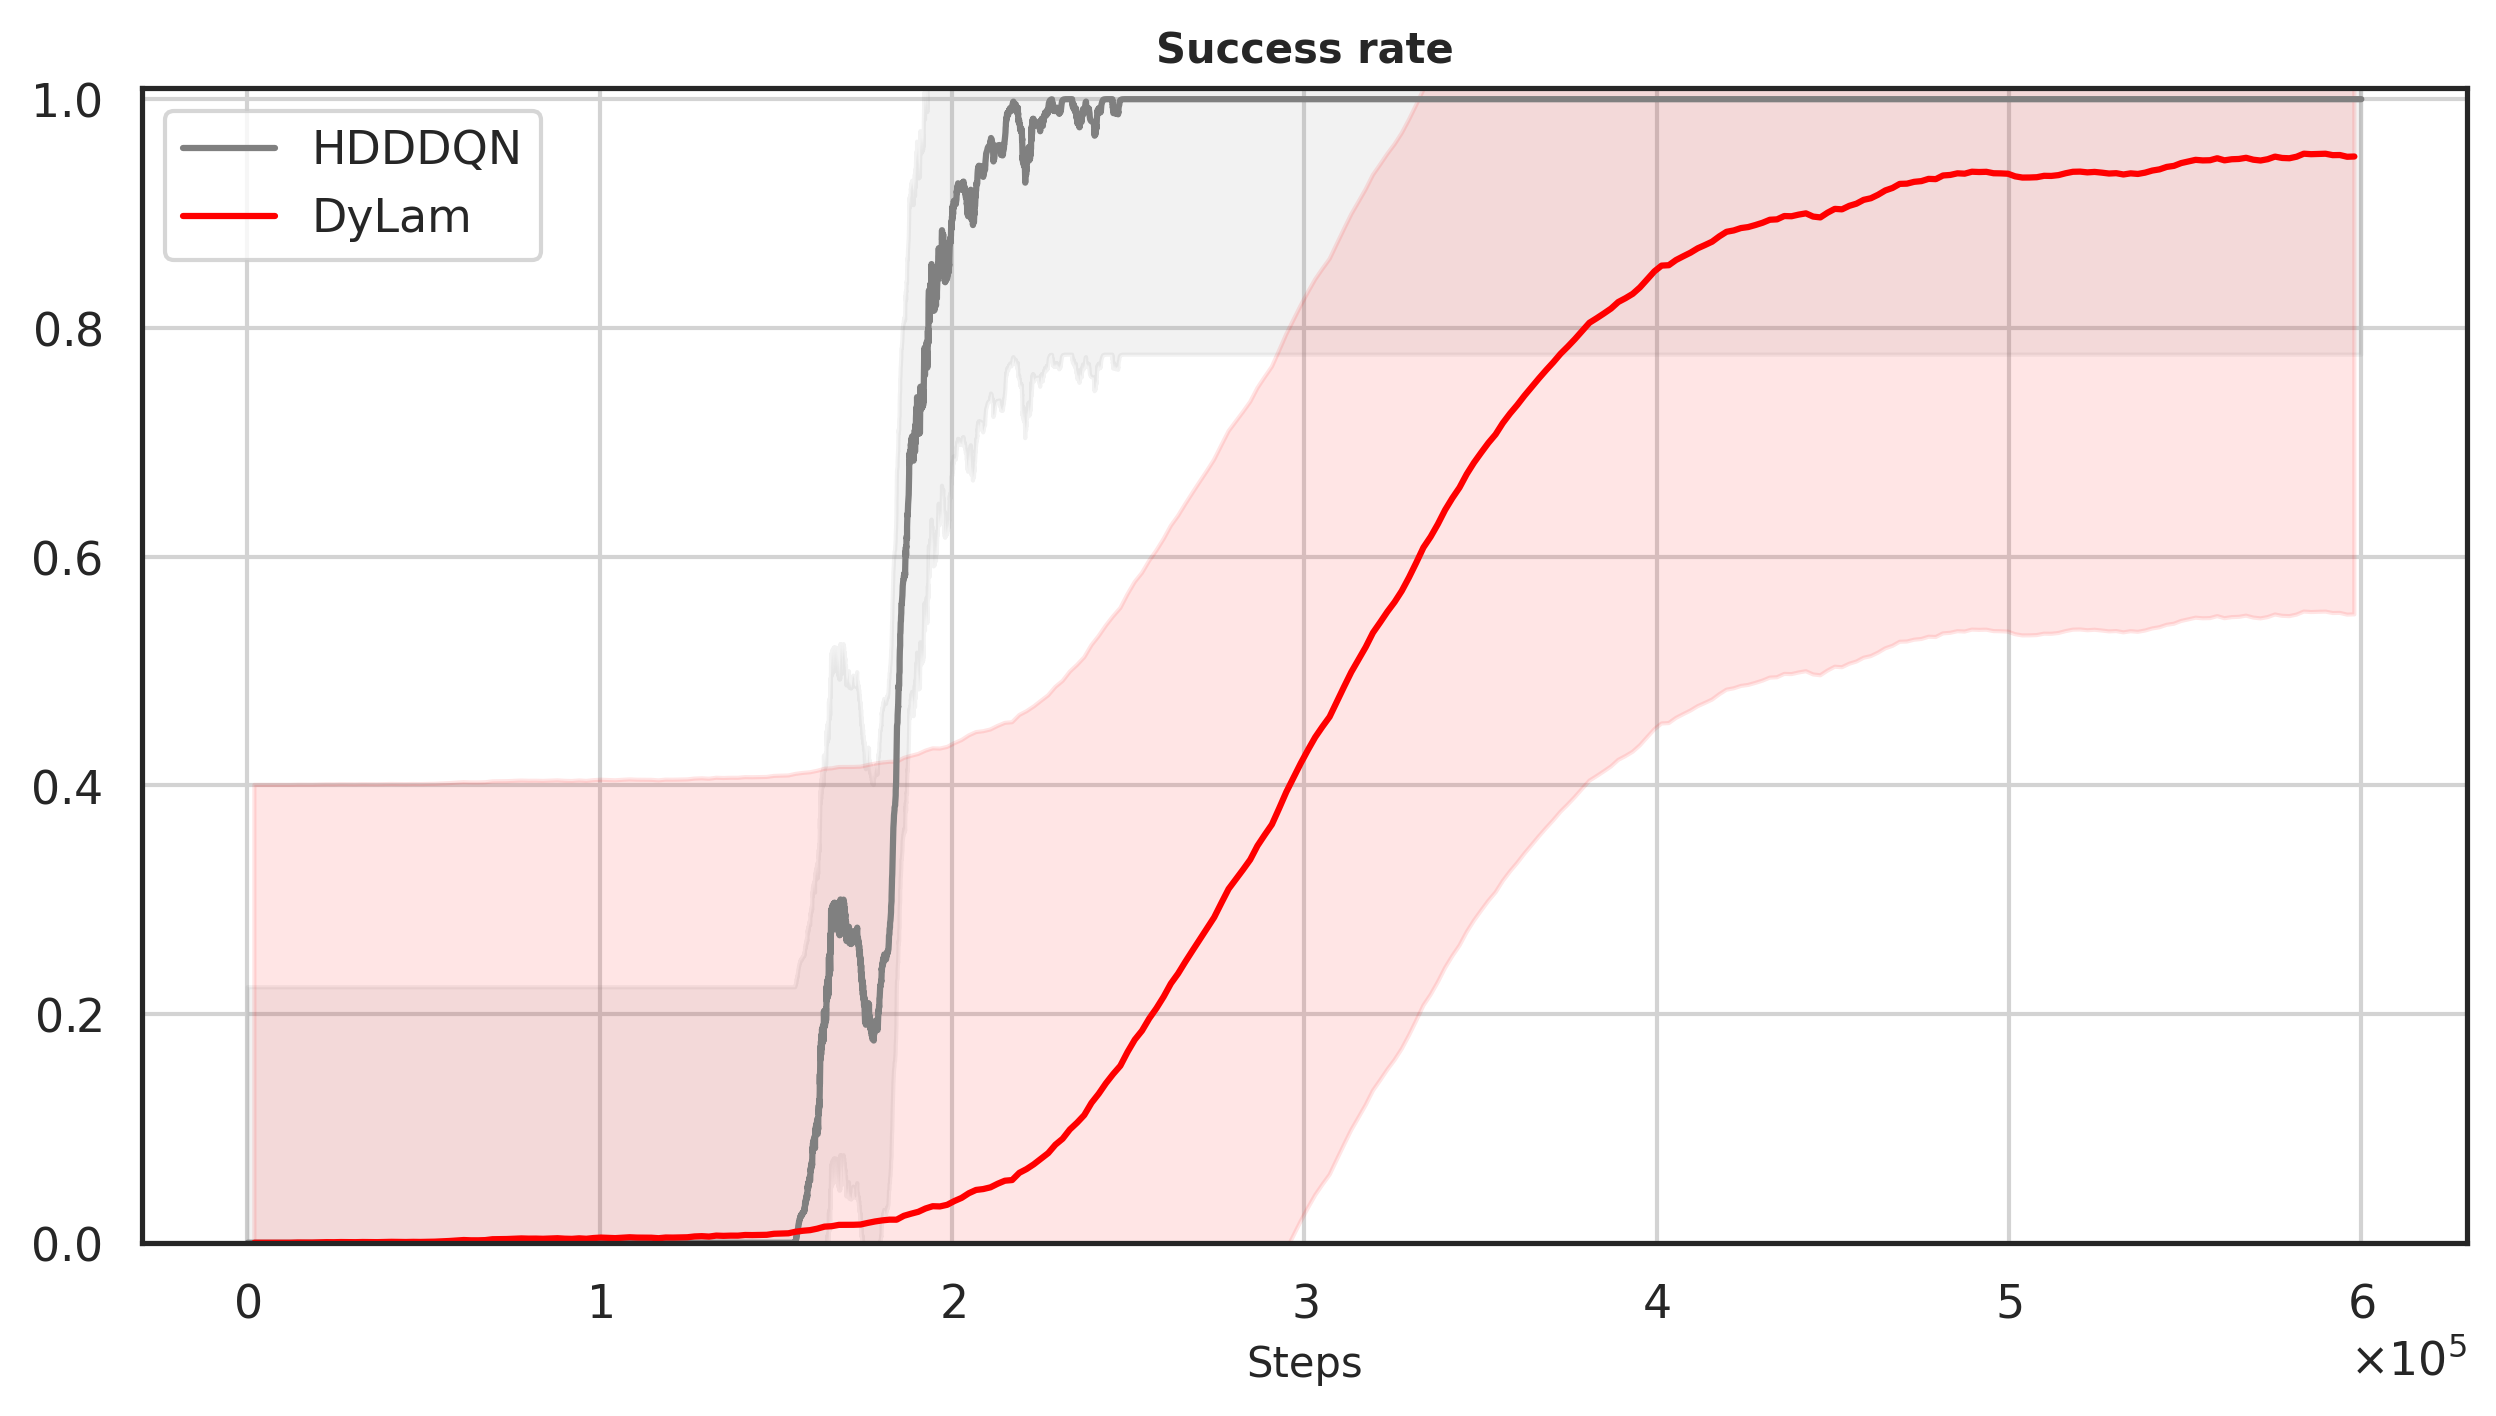

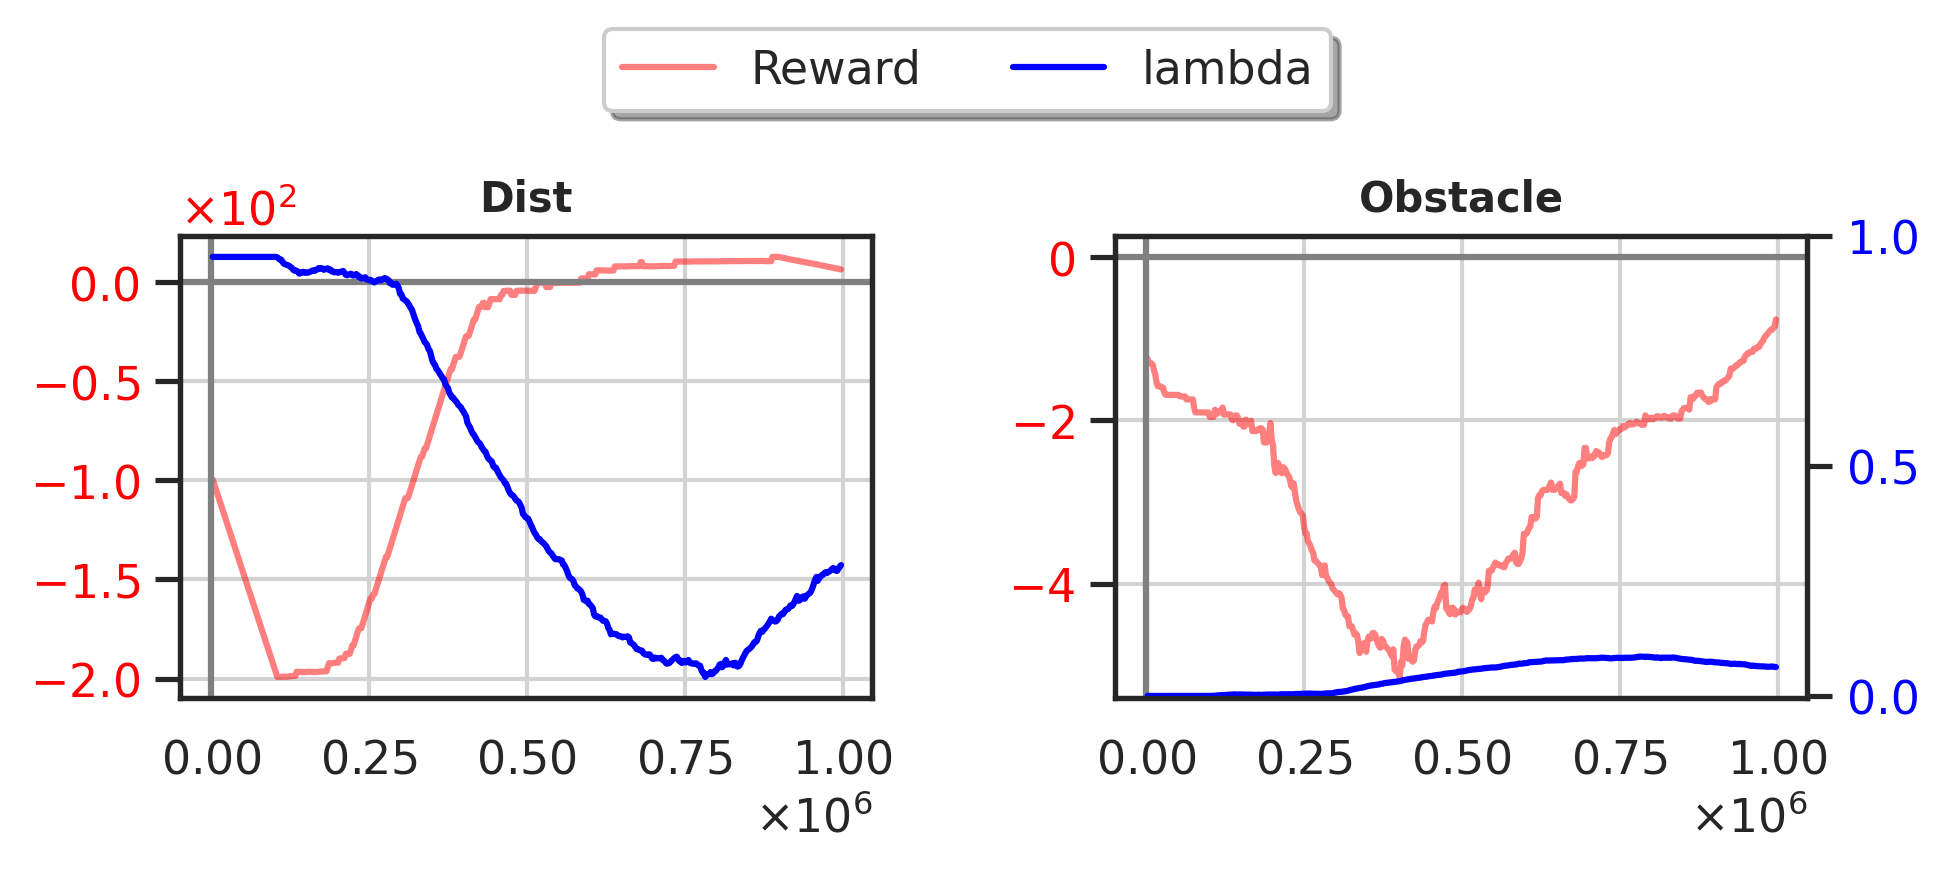

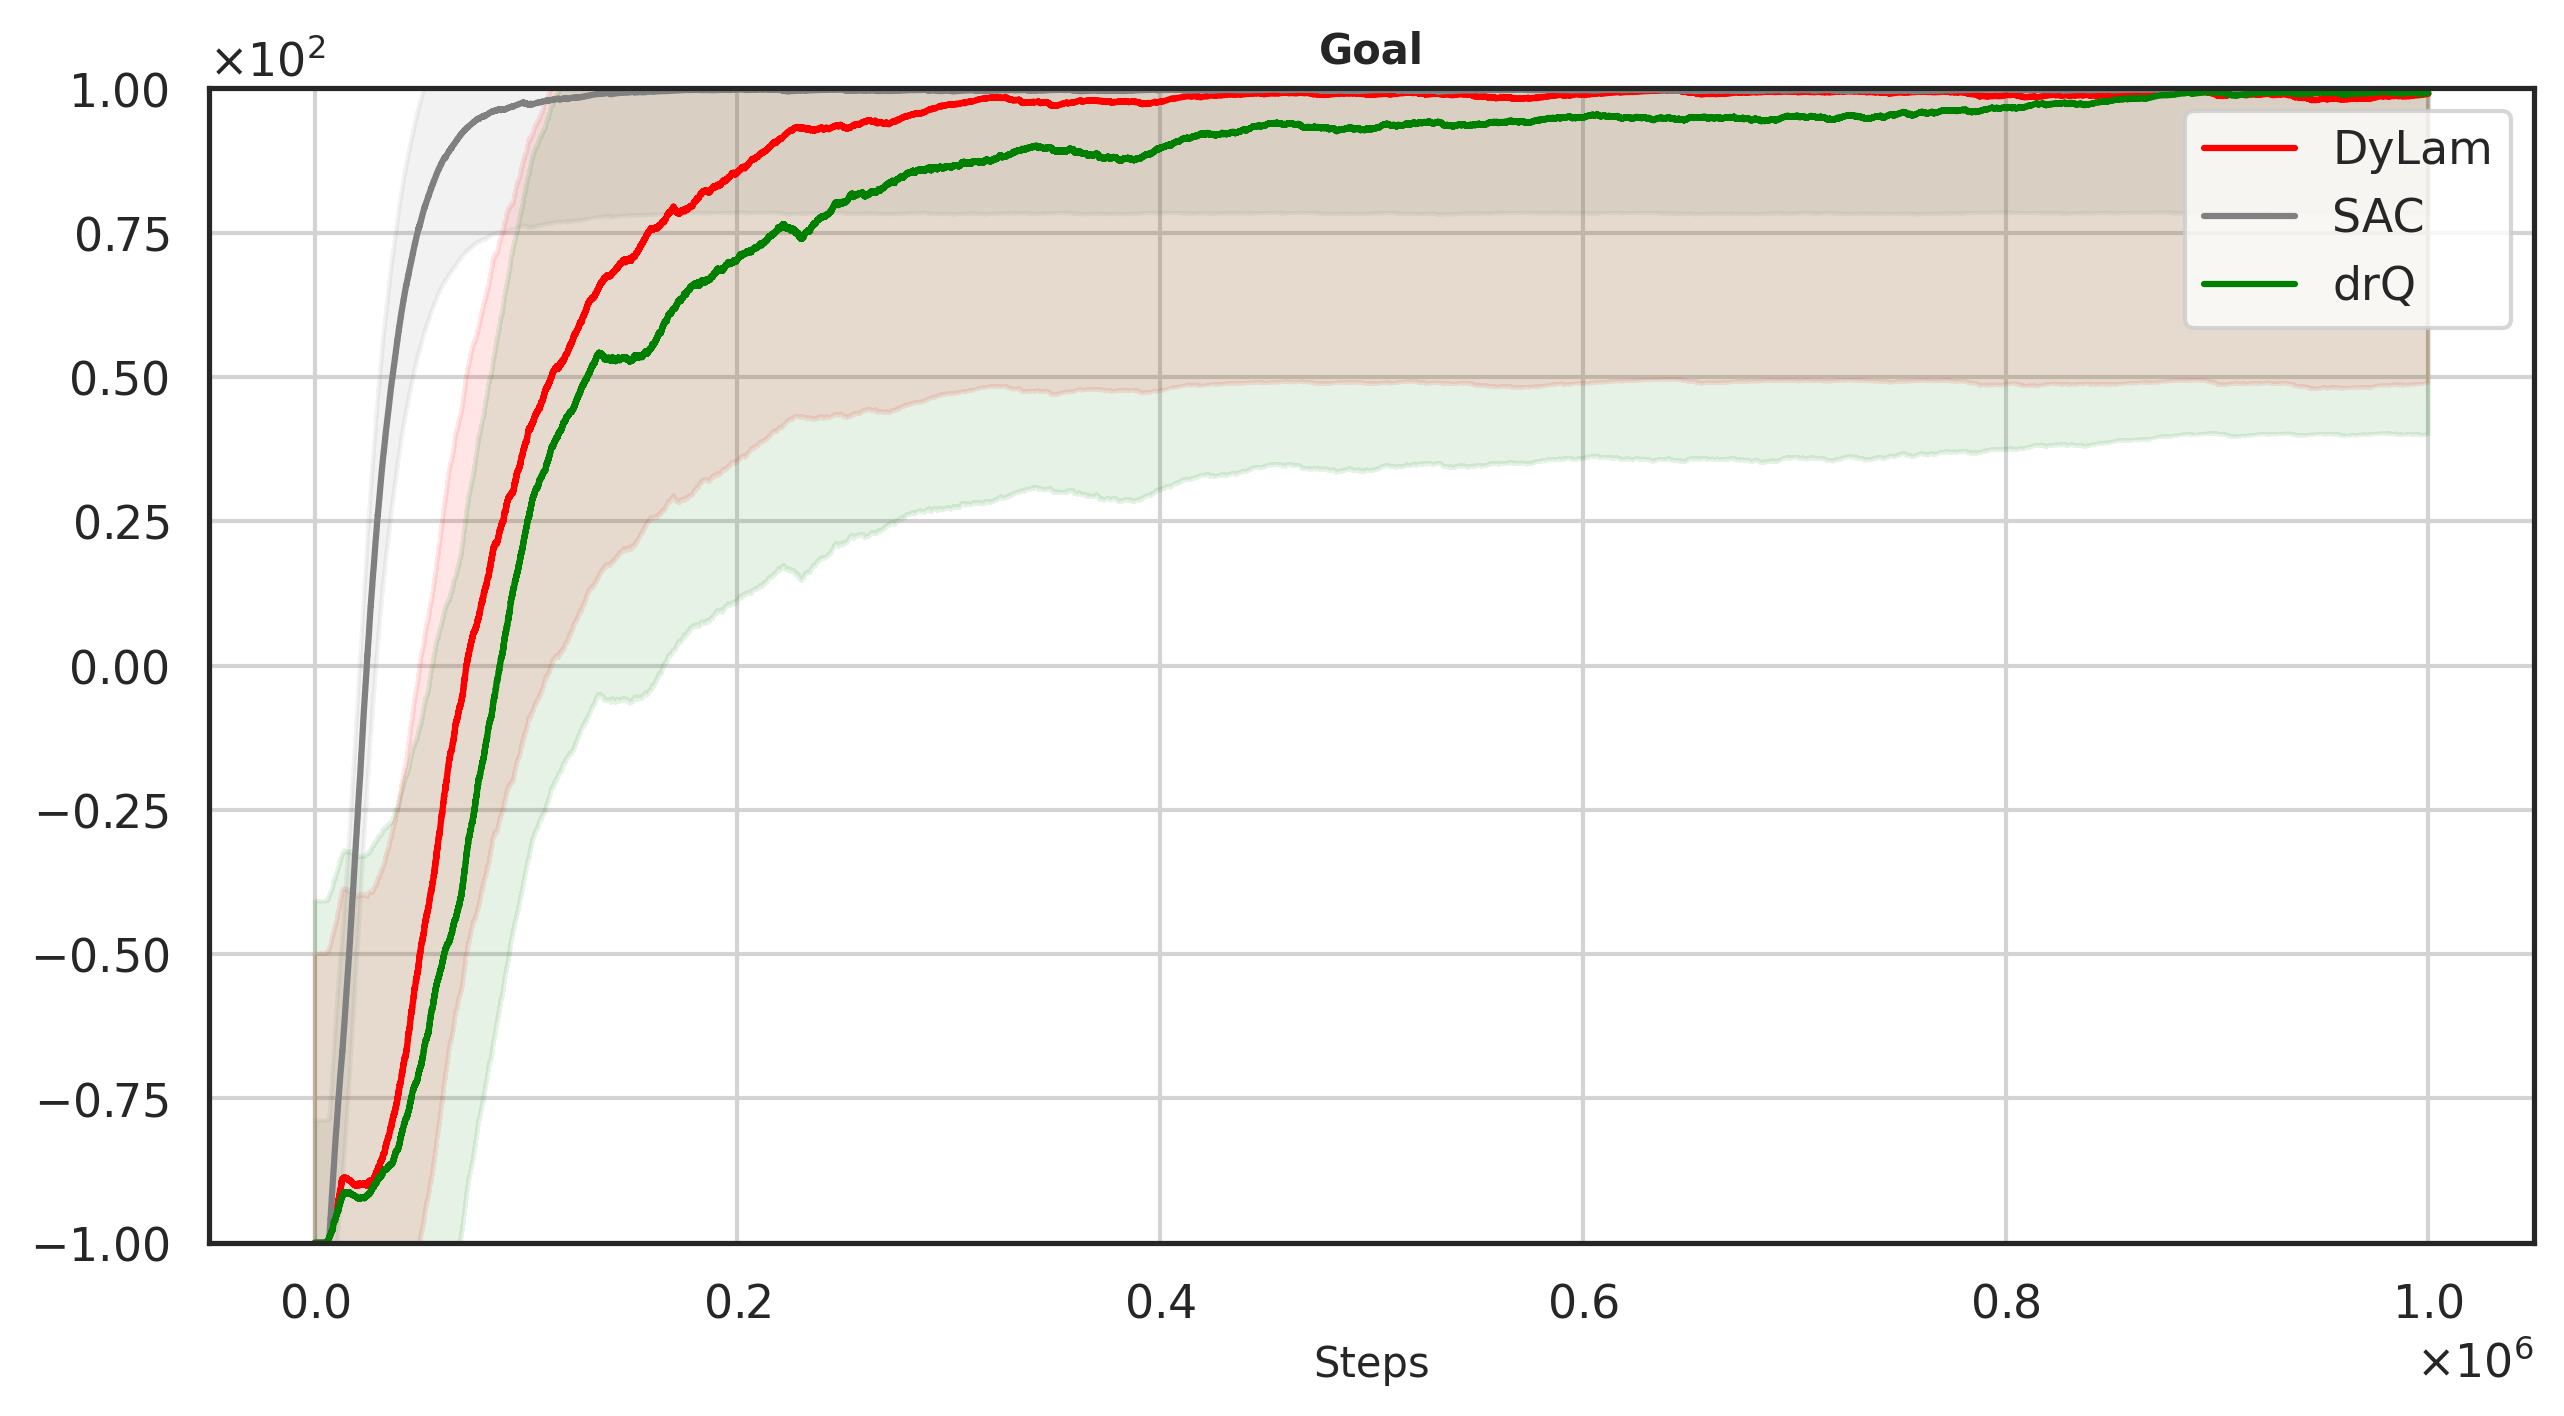

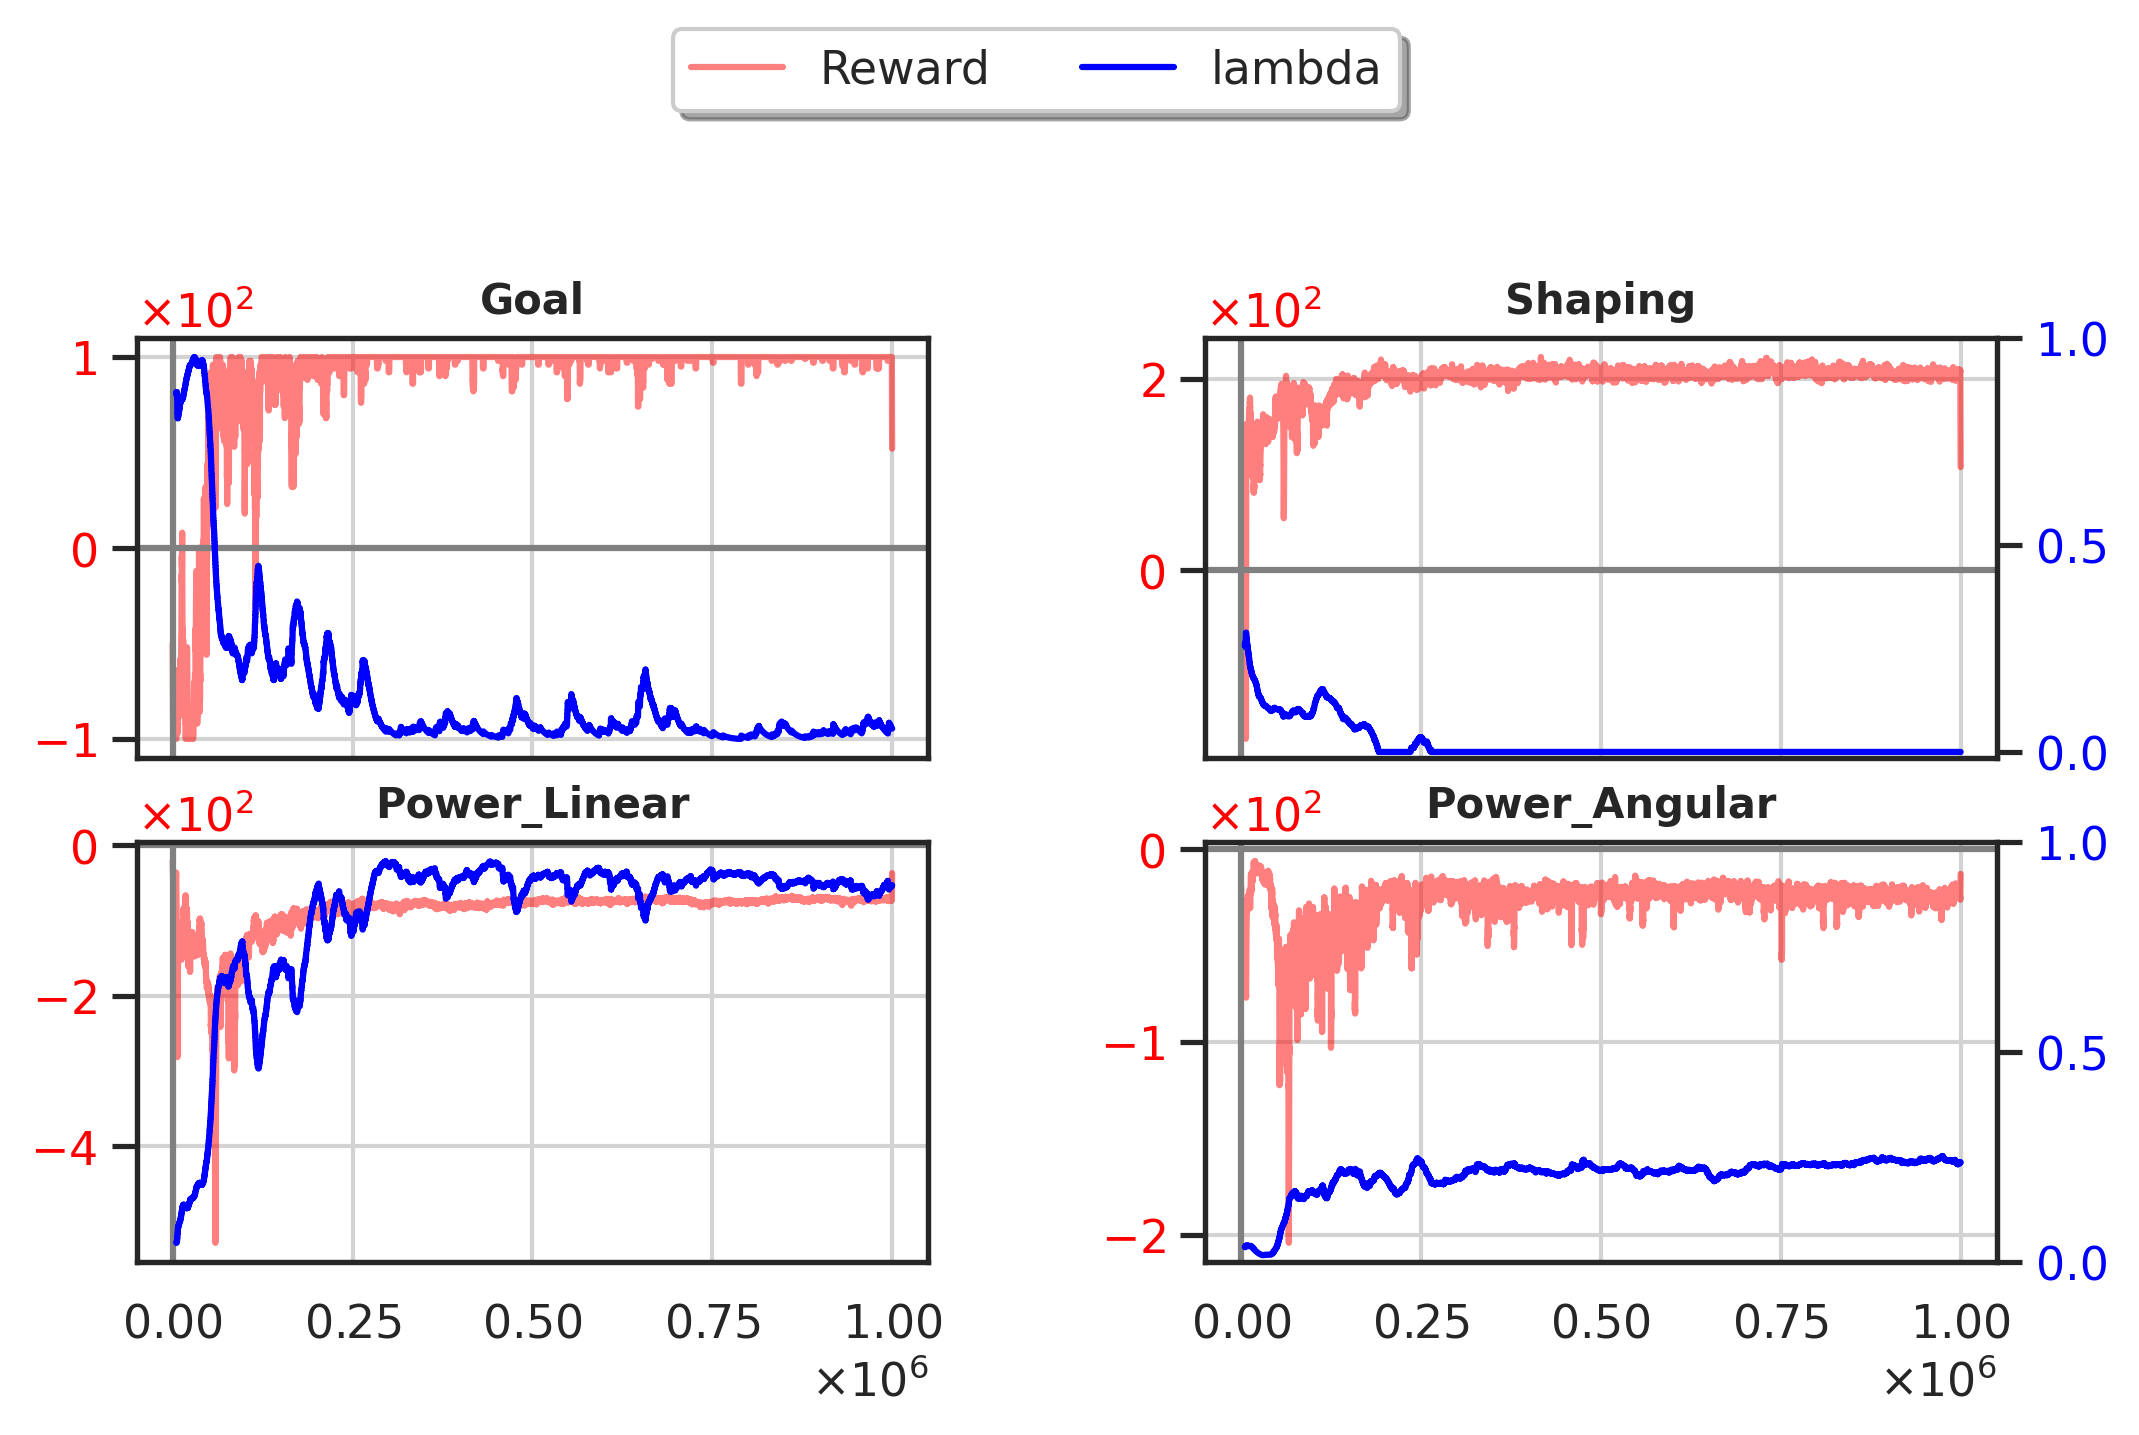

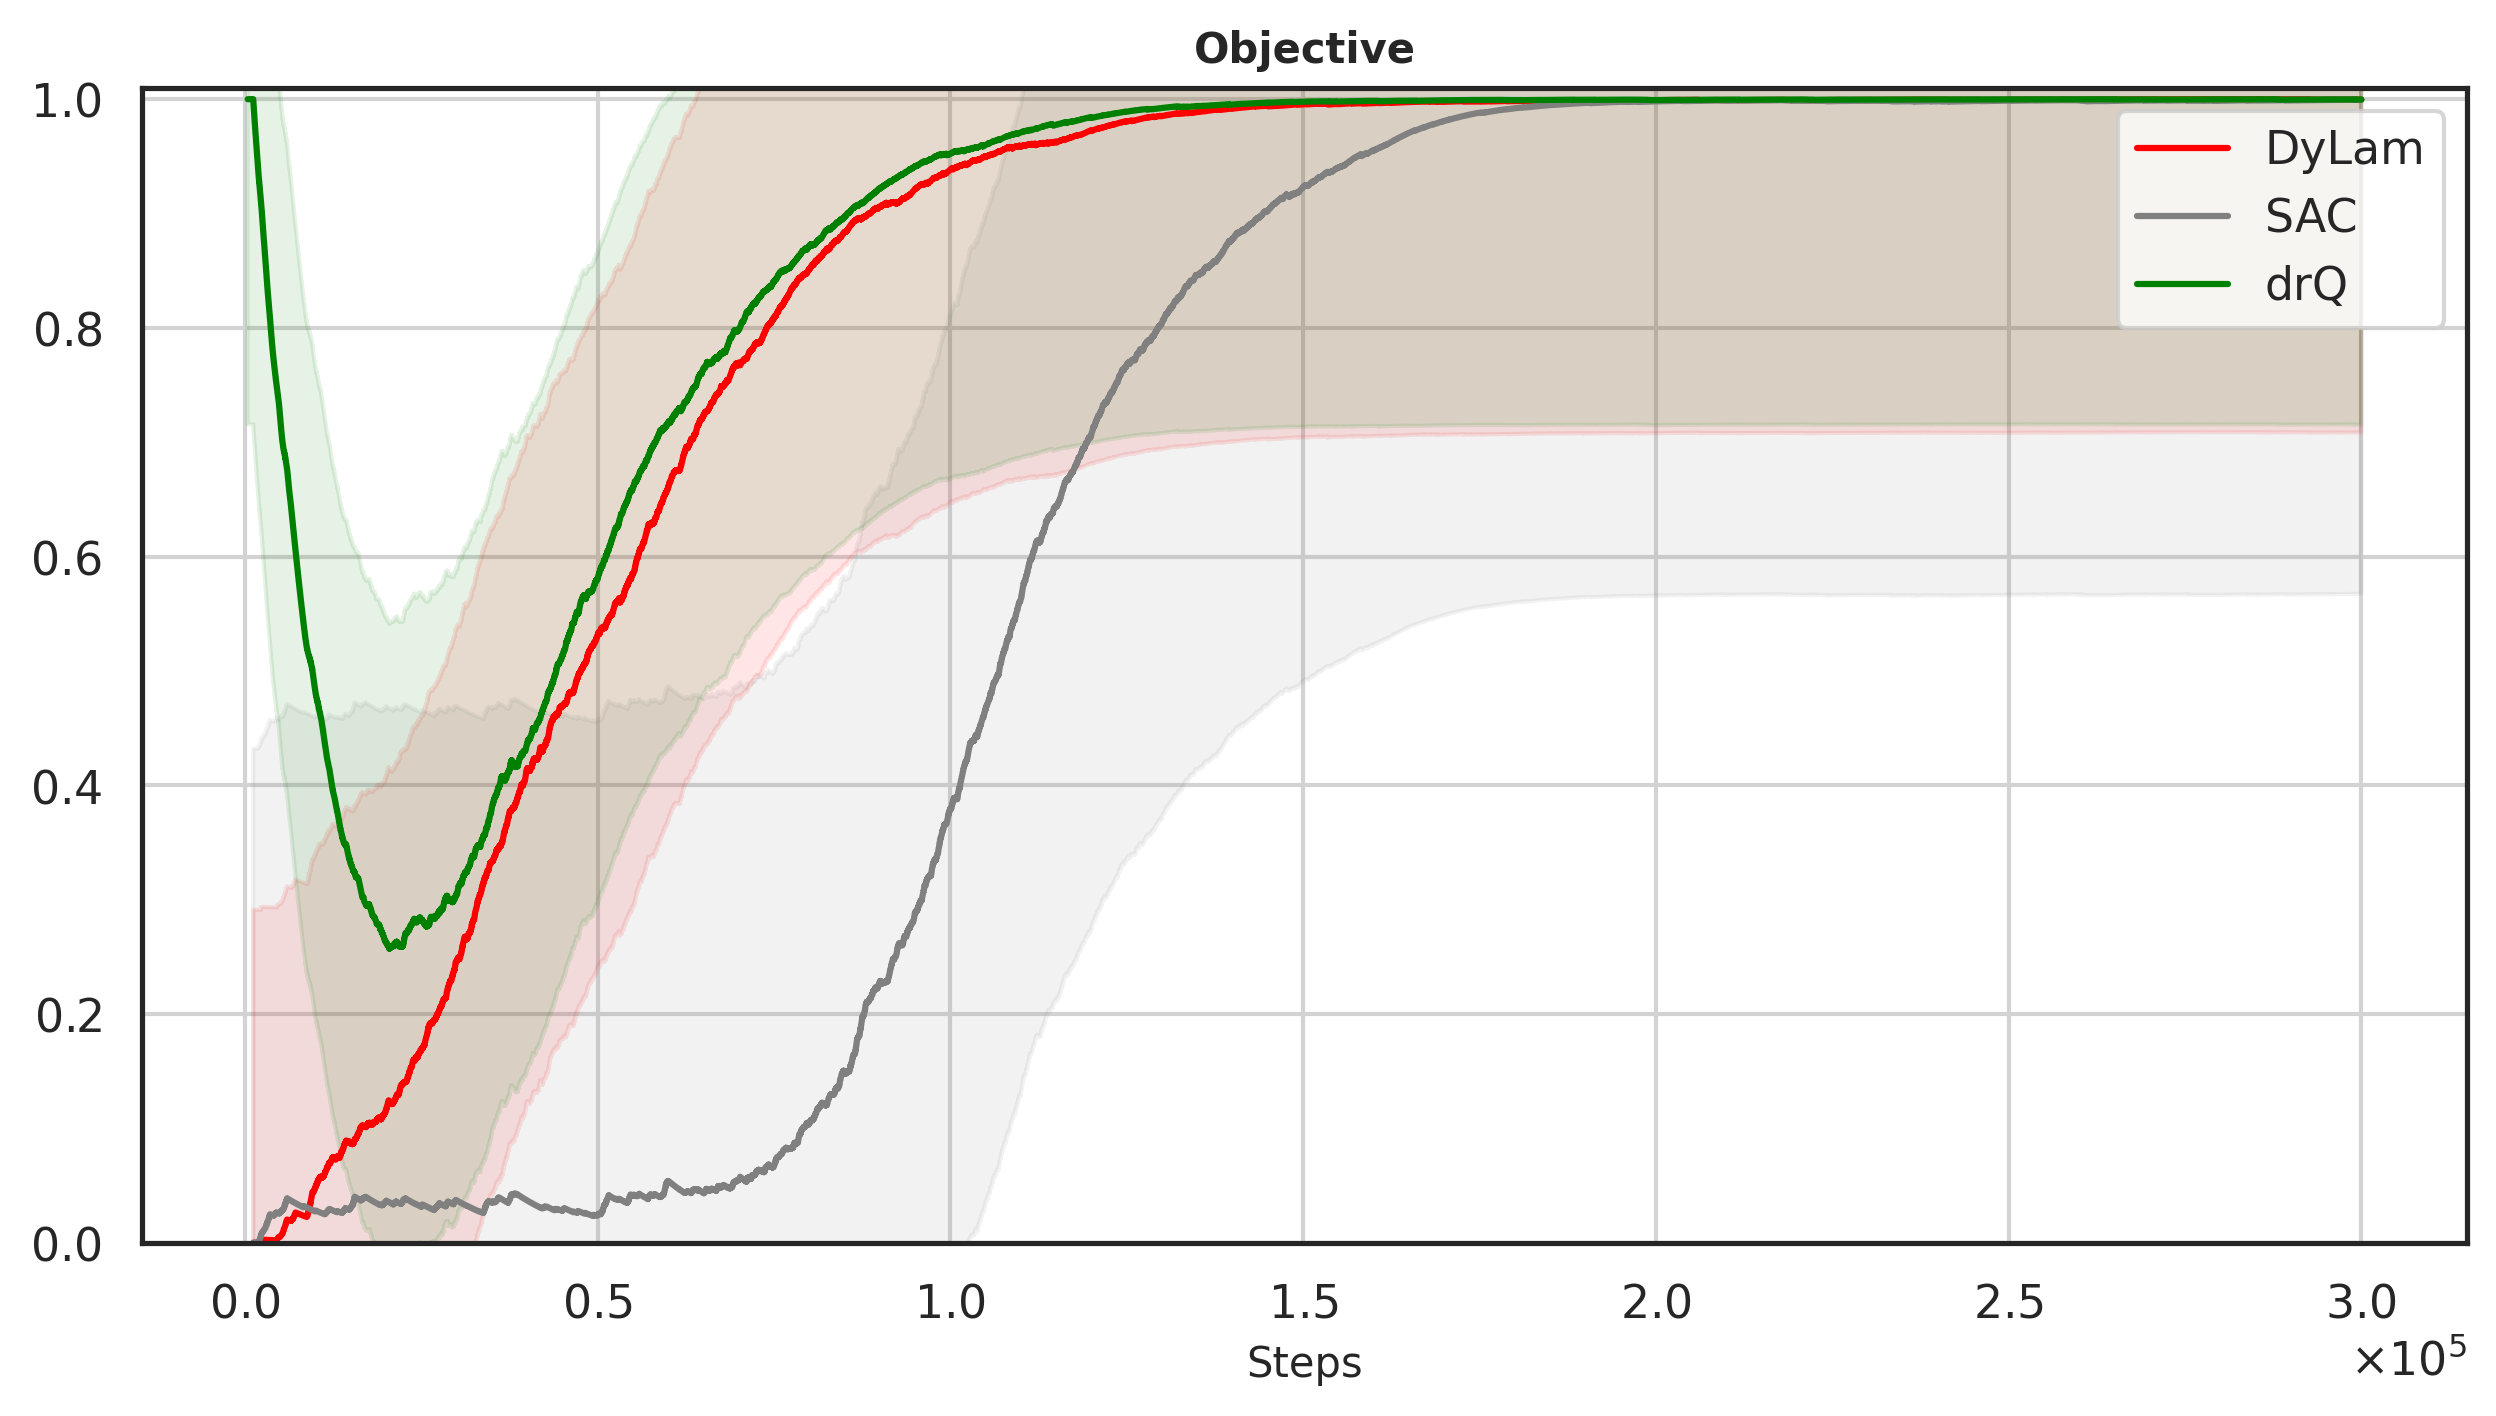

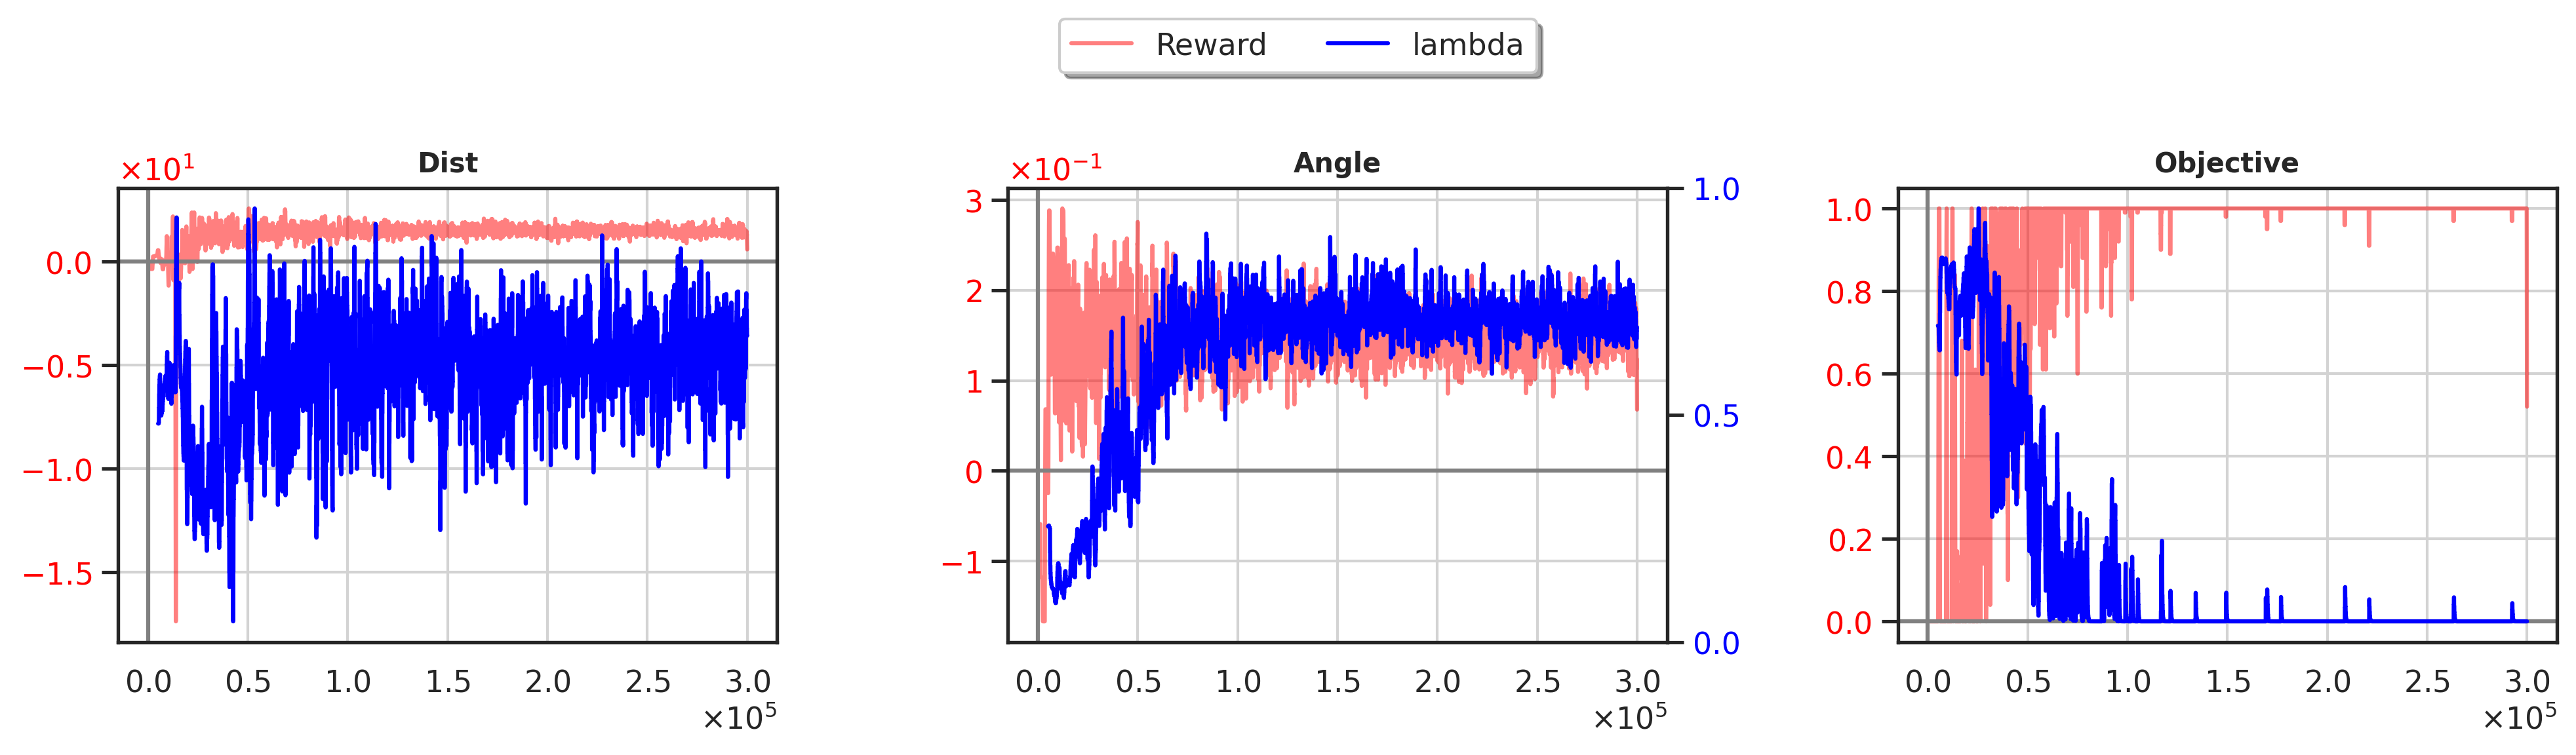

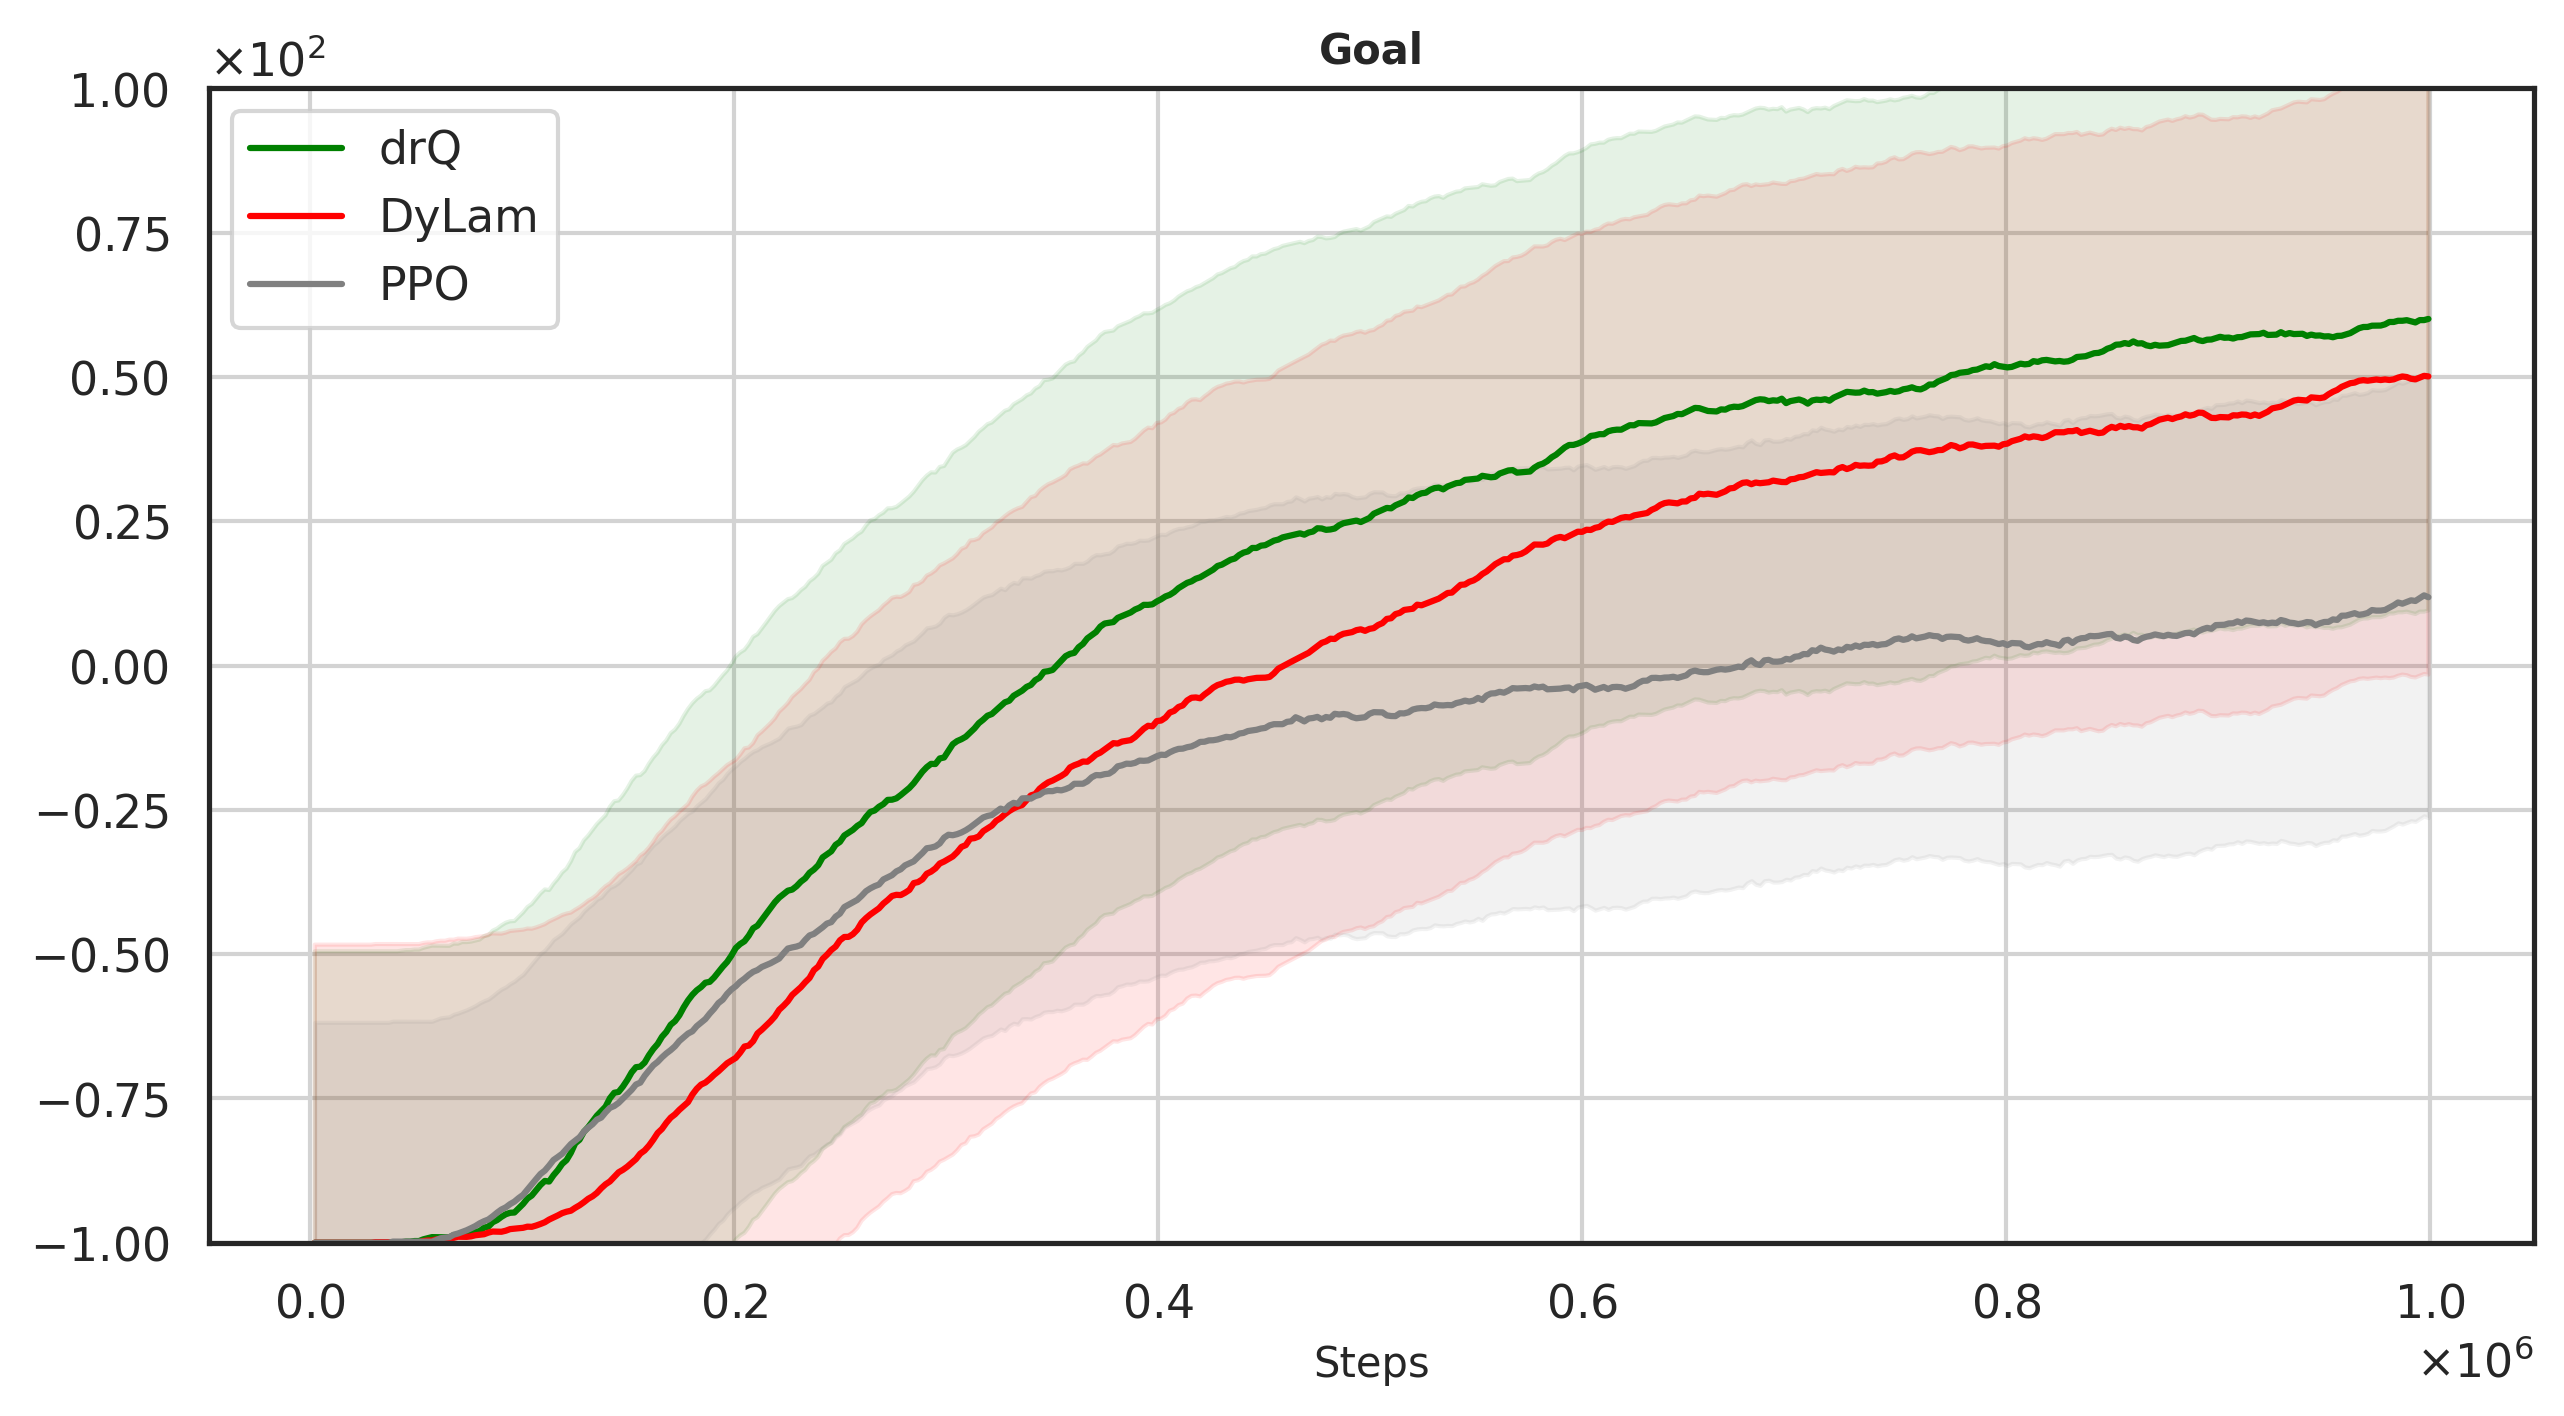

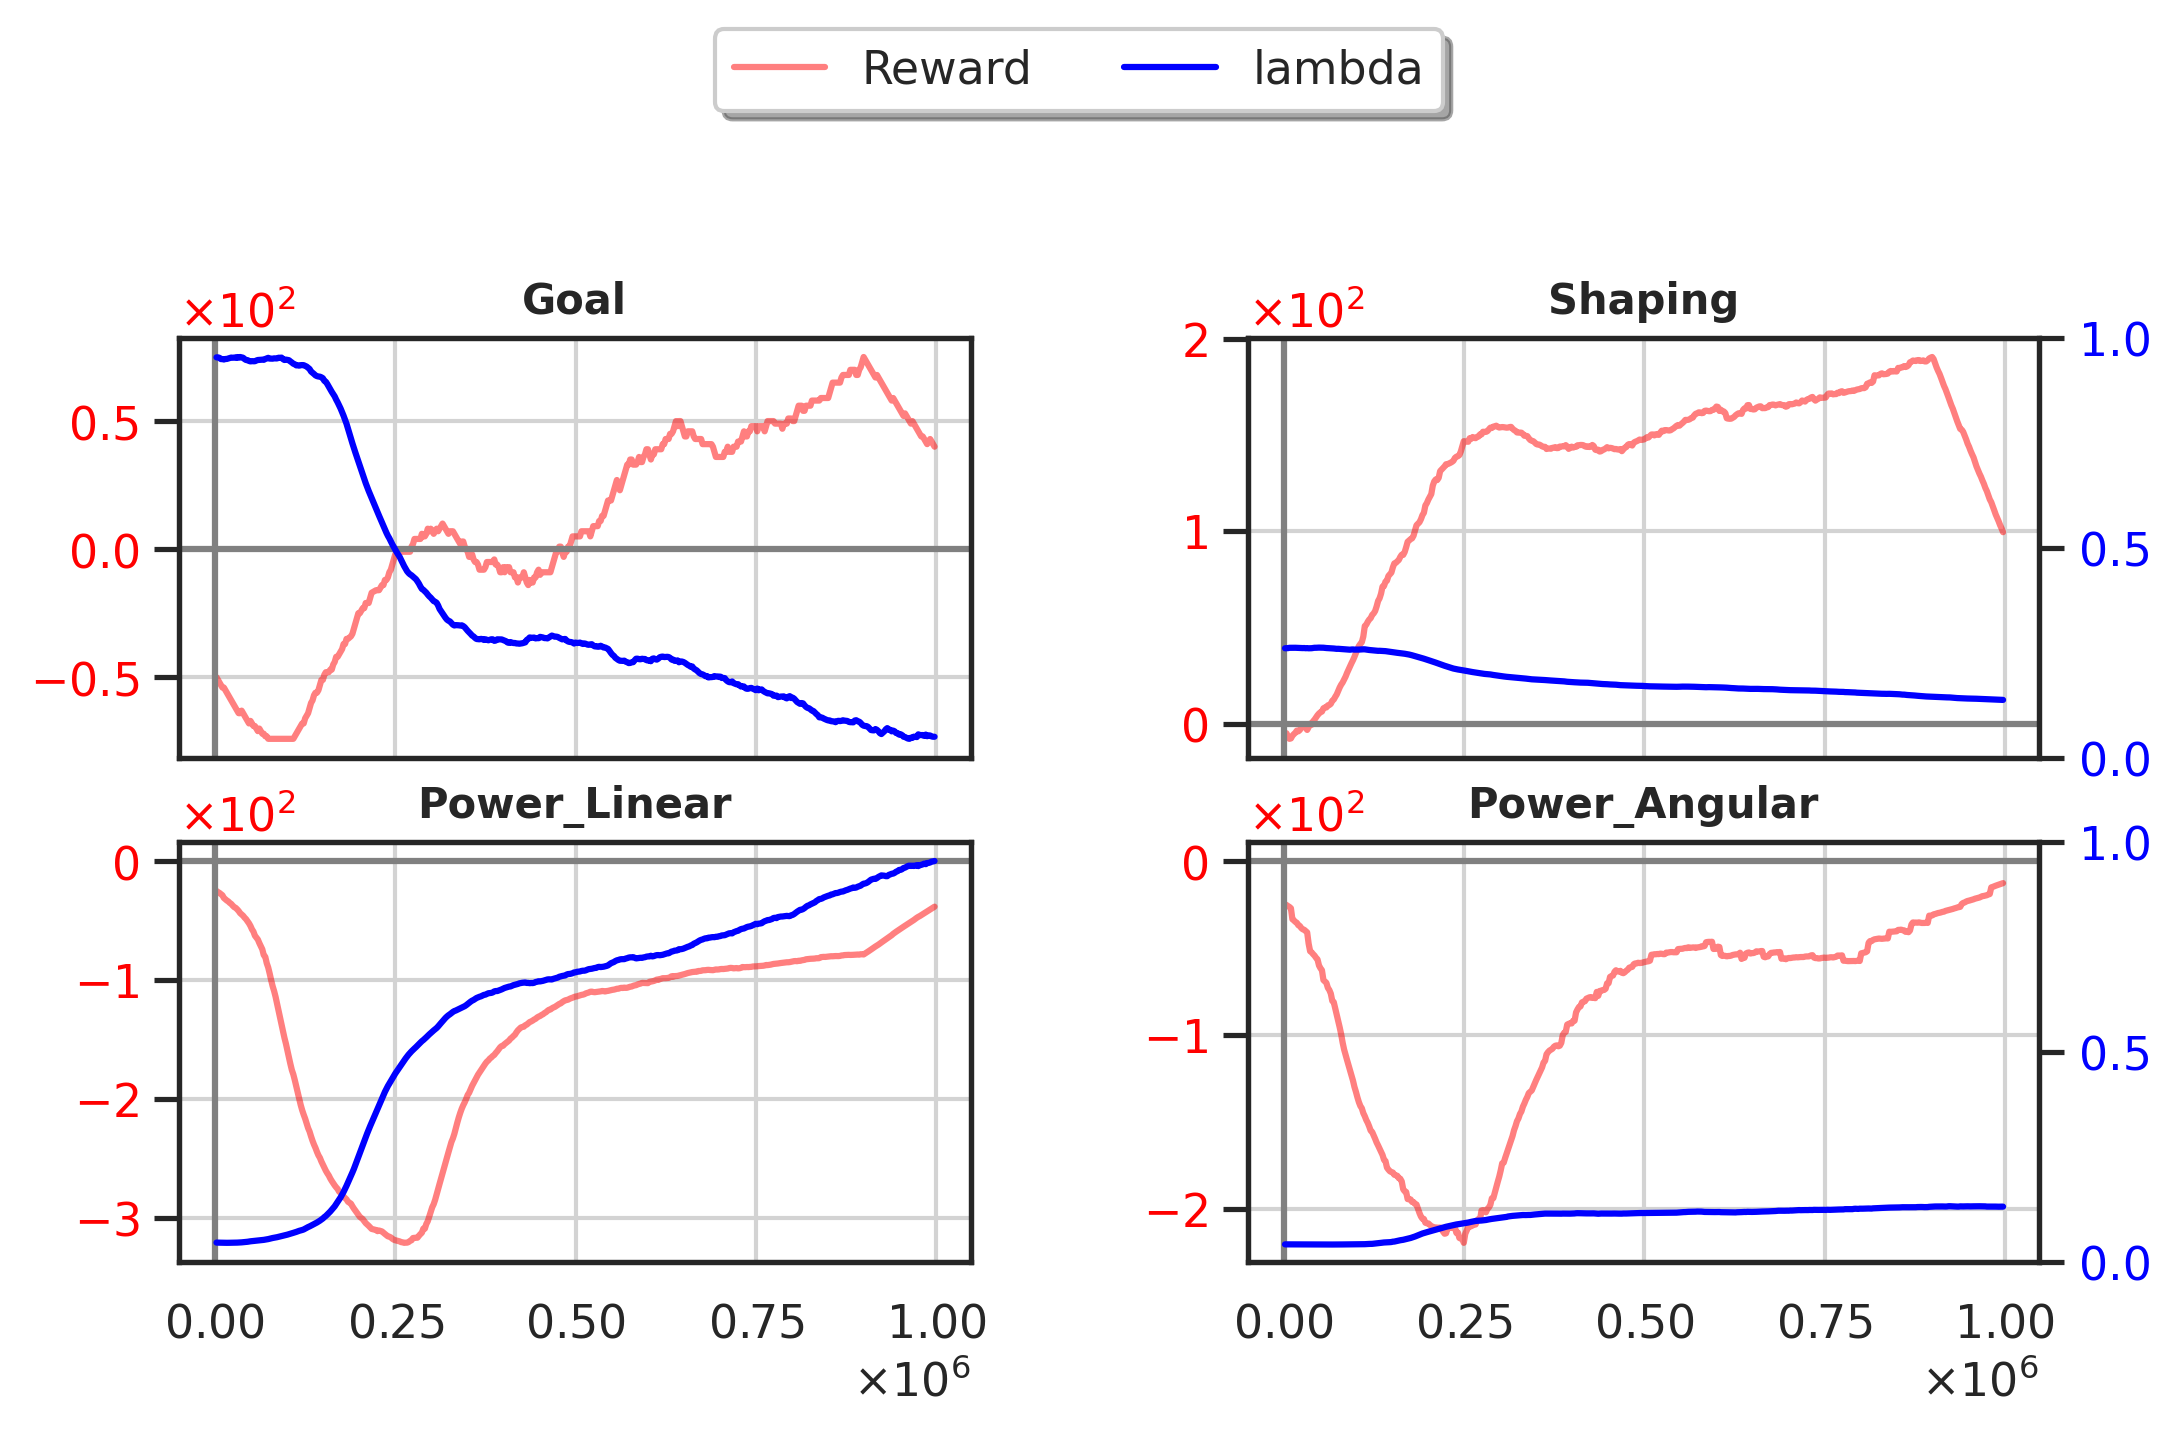

In [6]:
for env in environments:
    plot_results(env, results)
    plot_grid(lambdas, components, env)